##Downloads of packages and usefull imports.

In [1]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 2.6MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=14488031c2691cdf3555a87427770b4926e4f1861b53b9f02d265e0646588607
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=9f9cd0d92b06075310ccaf5fad71df64a9c5b098af5cd00c42f36d8943e3c69f
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=55019815c0e66d83c3c53b5acd296de8c54c98462532f545ebffb87cd18db3b7
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [2]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

#import nltk
#nltk.download('punkt')
#from nltk.corpus import stopwords
#nltk.download('stopwords')
#from nltk.stem import PorterStemmer

import os
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import bert
from bert.tokenization.bert_tokenization import FullTokenizer

#from bert import BertModelLayer
#from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Download the data from my personal drive(Google collab deletes folders) and store the concatenation of all the datasets into 'data/total.csv'.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
websites = ['amazon', 'imdb', 'yelp']
df_list_web=[]
for website in websites:
  df_web = pd.read_csv('/content/drive/My Drive/data/' + website + '_labelled.txt', sep="\\t", header=None)
  df_list_web.append(df_web)
df= pd.concat(df_list_web, axis=0, ignore_index=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [5]:
os.makedirs("data", exist_ok=True)

In [6]:
df.columns = ['text', 'score']
df.to_csv('data/total.csv')
df

,text,score
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
2995,I think food should have flavor and texture an...,0
2996,Appetite instantly gone.,0
2997,Overall I was not impressed and would not go b...,0
2998,"The whole experience was underwhelming, and I ...",0


#Data Analysys
Search any interesting facts that can help us on the preprocessing stages.

In [7]:
df.text.isnull().sum()

0

In [8]:
df.score.isnull().sum()

0

In [9]:
print('Positive review example: \n', df[df.score==1].text.values[0])
print('\n')
print('Negative review example: \n', df[df.score==0].text.values[0])

Positive review example: 
 Good case, Excellent value.


Negative review example: 
 So there is no way for me to plug it in here in the US unless I go by a converter.


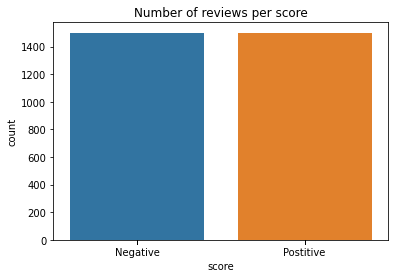

In [10]:
chart = sns.countplot(df.score)
plt.title("Number of reviews per score")
plt.xticks(df.score, ['Negative', 'Postitive']);

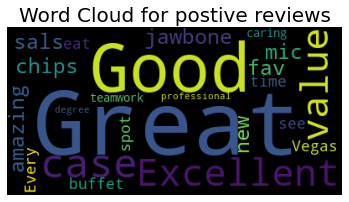

In [11]:
positive = df[(df['score']==1)]
wc_pos = WordCloud().generate(str(positive['text'].values))
negative = df[(df['score']==0)]
wc_neg = WordCloud().generate(str(negative['text'].values))

plt.figure()
plt.imshow(wc_pos)
plt.axis('off')
plt.title('Word Cloud for postive reviews',fontsize=20)
plt.show()

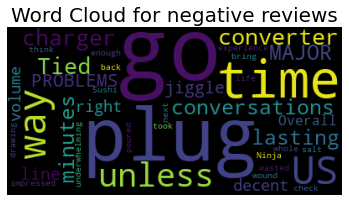

In [12]:
plt.figure()
plt.imshow(wc_neg)
plt.axis('off')
plt.title('Word Cloud for negative reviews',fontsize=20)
plt.show()    

The Word Clouds will give us a deep dive into the most common words for the either positive reviews or negative. As seen before, the most used words on positive reviews are great and good, while in the negative are plug and go. This gives as an idea of what type of reviews we have.

In this case the negatives usually have reference to some electric device as the plug word appears a lot.

#Preprocessing
Once the data is succesfully analyzed we will start the preprocessing taking into account important features from the previous step.

In [13]:
#Puntuation and numbers removal, most of them not providing information for sentiment analysis.
words = df.text.apply(lambda x: re.sub(r'\W+',' ',x))

#Lower Case all text
words = words.apply(lambda x: x.lower())

#Removal of Stop words
#stop_words = stopwords.words('english')
#tokens = words_lower.apply(lambda row: nltk.word_tokenize(row))
#words = tokens.apply(lambda x: [word for word in x if not word in stop_words])
#words = words.apply(lambda x: ' '.join(x))

#Stemming
#tokens = words_lower.apply(lambda row: nltk.word_tokenize(row))
#words = tokens.apply(lambda x: [ps.stem(w) for w in x])
#words = words.apply(lambda x: ' '.join(x))

#Add Changes to df.
df.text = words

We will keep stopwords as most of them bring negation and context information Bert is able to take profit of.
The same happens with Stemming or Lemmatization as the model losses information that helps to predict the sentiment.

#Downloading the model

In [14]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

--2020-09-18 07:14:34--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   159MB/s    in 2.4s    

2020-09-18 07:14:37 (159 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [15]:
os.makedirs("model", exist_ok=True)
!mv uncased_L-12_H-768_A-12/ model

In [16]:
bert_model_name= 'uncased_L-12_H-768_A-12'

bert_ckpt_dir = os.path.join('model/',bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, 'bert_model.ckpt')
bert_config_file = os.path.join(bert_ckpt_dir, 'bert_config.json')

#Preprocessing data for Bert
In order to make the pretrained language model(Bert) understand our data it has to come on a specific format. To achieve this we developed a class with some functions to perform all the steps.

The init function initializes the class with all the parameters that we pass on it.

The encodebert converts the train/test dataset into train_x/test_y and train_y/test_y. The text is converted to tokens and added some special caracthers needed to delimiter sentences.

The pad, appart from padding the sentences to the length of the largest, it creates the token_ids, the mask_id and the input_type_ids matrixs. 

In [17]:
class BertData:

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer=tokenizer
    self.max_seq_len=0
    self.classes=classes

    ((self.train_x, self.train_y), (self.test_x,self.test_y)) = map(self._encodebert, [train,test])

    self.max_seq_len=min(self.max_seq_len,max_seq_len)
    
    ((self.train_x, self.train_mask, self.train_type), (self.test_x, self.test_mask, self.test_type)) = map(self._pad,[self.train_x, self.test_x])
  

  def _encodebert(self, df):
    x, y= [], []
    for _,row in tqdm(df.iterrows()):
      text,label= row['text'], row['score']

      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"]+tokens+["[SEP]"]

      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

      self.max_seq_len= max(self.max_seq_len, len(token_ids))

      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)


  def _pad(self, ids):
    #print("Max_Seq_Len Value:", self.max_seq_len)
    x, y, z =[],[], []
    
    for input_ids in ids:
      
      #Mask generation:
      mask = ([1] * len(input_ids)) + ([0] *  (self.max_seq_len - len(input_ids)))
      #Input type generation:
      input_type = ([0] * (len(input_ids)-1)) + [1] + ([0] *  (self.max_seq_len - len(input_ids)))
      #Input ids generation:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))

      x.append(np.array(input_ids))
      y.append(np.array(mask))
      z.append(np.array(input_type))

    return np.array(x), np.array(y), np.array(z)



In [18]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir,"vocab.txt"))

In [19]:
#tokenizer.tokenize("I can't wait to learn about Deep Learning.")

In [20]:
import tensorflow_hub as hub
bert_path = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
bert_layer = hub.KerasLayer(bert_path, trainable=True)

#Model Creation
To make Bert work correctly, we need the data in the format mentioned before. So the input to the bert layer will be [input_ids, input_mask, input_segments]. Then we fine-tune the lasts layers in order to make the model be able to perform corretly on our type of problem, in our case, sentiment analysis.

In [21]:
def create_model(max_seq_len):

  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  input_mask = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_masks")
  input_segments = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_segments")

  _,bert_output = bert_layer([input_ids, input_mask, input_segments])
  cls_out = keras.layers.GlobalAveragePooling1D()(bert_output)
  logits = keras.layers.Dropout(0.7)(cls_out)
  logits = keras.layers.Dense(units=768)(logits)
  logits = keras.layers.Dropout(0.7)(logits)

  #Enable the row below when logits=True
  logits = keras.layers.Dense(units=1, activation="sigmoid")(logits)

  #Enable the row below when Loss logits=False, worse results thant with logits
  #logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model([input_ids, input_mask, input_segments],logits)
        
  return model

#Kfold

The difference of this notebook is the need to introduce K-fold Cross-validation in order to generalize better our model. As the random state is fixed to be able to reproduce our models, we introduced the CV method to demonstrate that it works well with more than one test dataset, in specific with K different tests sets.

In [23]:
from sklearn.model_selection import KFold
kfold = KFold(5, shuffle=True, random_state=42)
fold = 0
fold_y = []
fold_pred = []
for train_ids, test_ids in kfold.split(df):
  fold +=1
  train = pd.concat([df.text[train_ids],df.score[train_ids]],axis = 1)
  test = pd.concat([df.text[test_ids], df.score[test_ids]], axis = 1)
  classes = train.score.unique().tolist()
  data = BertData(train, test, tokenizer, classes, max_seq_len=128)
  model = create_model(data.max_seq_len)
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 1e-5, epsilon= 1e-8, clipnorm=1.0),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])
  bert_input = [tf.cast(data.train_x, tf.int32), tf.cast(data.train_mask, tf.int32), tf.cast(data.train_type, tf.int32)]
  
  earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

  checkpoint = ModelCheckpoint('model/best.h5',
                             monitor='loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
  
  print('\nFold:', fold,'\n')
  print('----------------------------')
  model.fit(
    x=bert_input, 
    y=data.train_y,  
    batch_size=16,
    epochs=5,
    callbacks=[earlystop, checkpoint]
    )
  bert_test_inp = [tf.cast(data.test_x, tf.int32), tf.cast(data.test_mask, tf.int32), tf.cast(data.test_type, tf.int32)]
  y_test_pred = model.predict(bert_test_inp)
  y_test_pred2=[]
  for i in y_test_pred:
    if (i < 0.5):
      i= 0
    else:
      i = 1
    y_test_pred2.append(i)
  fold_y.append(data.test_y)
  fold_pred.append(y_test_pred2)
  

2400it [00:00, 3228.04it/s]
600it [00:00, 3201.41it/s]



Fold: 1 

----------------------------
Epoch 1/5
150/150 [==============================] - ETA: 0s - loss: 0.5417 - accuracy: 0.9179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00001: loss improved from inf to 0.54170, saving model to model/best.h5
150/150 [==============================] - 53s 350ms/step - loss: 0.5417 - accuracy: 0.9179
Epoch 2/5
150/150 [==============================] - ETA: 0s - loss: 0.5193 - accuracy: 0.9629WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00002: loss improved from 0.54170 to 0.51930, saving model to model/best.h5
150/150 [==============================] - 52s 345ms/step - loss: 0.5193 - accuracy: 0.9629
Epoch 3/5
150/150 [==============================] - ETA: 0s - loss: 0.5156 - accuracy: 0.9733WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00003: loss improved from 0.51930 to 0.51555, saving model to model/best.h5
150/150 [==============================] - 52s 348ms/step - loss: 0.5156 - accuracy: 0.9733
Epoch 4/5
150/150 [==============================] - ETA: 0s - loss: 0.5147 - accuracy: 0.9737WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00004: loss improved from 0.51555 to 0.51471, saving model to model/best.h5
150/150 [==============================] - 52s 346ms/step - loss: 0.5147 - accuracy: 0.9737
Epoch 5/5
150/150 [==============================] - ETA: 0s - loss: 0.5144 - accuracy: 0.9746WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00005: loss improved from 0.51471 to 0.51437, saving model to model/best.h5
150/150 [==============================] - 52s 347ms/step - loss: 0.5144 - accuracy: 0.9746


2400it [00:00, 3282.69it/s]
600it [00:00, 3388.99it/s]



Fold: 2 

----------------------------
Epoch 1/5
150/150 [==============================] - ETA: 0s - loss: 0.5305 - accuracy: 0.9433WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00001: loss improved from inf to 0.53053, saving model to model/best.h5
150/150 [==============================] - 53s 351ms/step - loss: 0.5305 - accuracy: 0.9433
Epoch 2/5
150/150 [==============================] - ETA: 0s - loss: 0.5144 - accuracy: 0.9725WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00002: loss improved from 0.53053 to 0.51438, saving model to model/best.h5
150/150 [==============================] - 52s 344ms/step - loss: 0.5144 - accuracy: 0.9725
Epoch 3/5
150/150 [==============================] - ETA: 0s - loss: 0.5108 - accuracy: 0.9796WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00003: loss improved from 0.51438 to 0.51084, saving model to model/best.h5
150/150 [==============================] - 52s 347ms/step - loss: 0.5108 - accuracy: 0.9796
Epoch 4/5
150/150 [==============================] - ETA: 0s - loss: 0.5106 - accuracy: 0.9792WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00004: loss improved from 0.51084 to 0.51065, saving model to model/best.h5
150/150 [==============================] - 52s 346ms/step - loss: 0.5106 - accuracy: 0.9792
Epoch 5/5
150/150 [==============================] - ETA: 0s - loss: 0.5087 - accuracy: 0.9842WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00005: loss improved from 0.51065 to 0.50874, saving model to model/best.h5
150/150 [==============================] - 52s 346ms/step - loss: 0.5087 - accuracy: 0.9842


2400it [00:00, 3373.15it/s]
600it [00:00, 3454.60it/s]



Fold: 3 

----------------------------
Epoch 1/5
150/150 [==============================] - ETA: 0s - loss: 0.5230 - accuracy: 0.9679WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00001: loss improved from inf to 0.52296, saving model to model/best.h5
150/150 [==============================] - 53s 352ms/step - loss: 0.5230 - accuracy: 0.9679
Epoch 2/5
150/150 [==============================] - ETA: 0s - loss: 0.5126 - accuracy: 0.9829WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00002: loss improved from 0.52296 to 0.51260, saving model to model/best.h5
150/150 [==============================] - 52s 346ms/step - loss: 0.5126 - accuracy: 0.9829
Epoch 3/5
150/150 [==============================] - ETA: 0s - loss: 0.5128 - accuracy: 0.9821WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00003: loss did not improve from 0.51260
150/150 [==============================] - 47s 314ms/step - loss: 0.5128 - accuracy: 0.9821
Epoch 4/5
150/150 [==============================] - ETA: 0s - loss: 0.5110 - accuracy: 0.9862WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00004: loss improved from 0.51260 to 0.51102, saving model to model/best.h5
150/150 [==============================] - 52s 346ms/step - loss: 0.5110 - accuracy: 0.9862
Epoch 5/5
150/150 [==============================] - ETA: 0s - loss: 0.5108 - accuracy: 0.9858WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00005: loss improved from 0.51102 to 0.51082, saving model to model/best.h5
150/150 [==============================] - 52s 348ms/step - loss: 0.5108 - accuracy: 0.9858


2400it [00:00, 3185.11it/s]
600it [00:00, 3350.46it/s]



Fold: 4 

----------------------------
Epoch 1/5
150/150 [==============================] - ETA: 0s - loss: 0.5226 - accuracy: 0.9617WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00001: loss improved from inf to 0.52262, saving model to model/best.h5
150/150 [==============================] - 53s 353ms/step - loss: 0.5226 - accuracy: 0.9617
Epoch 2/5
150/150 [==============================] - ETA: 0s - loss: 0.5082 - accuracy: 0.9867WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00002: loss improved from 0.52262 to 0.50823, saving model to model/best.h5
150/150 [==============================] - 52s 348ms/step - loss: 0.5082 - accuracy: 0.9867
Epoch 3/5
150/150 [==============================] - ETA: 0s - loss: 0.5062 - accuracy: 0.9908WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00003: loss improved from 0.50823 to 0.50622, saving model to model/best.h5
150/150 [==============================] - 52s 349ms/step - loss: 0.5062 - accuracy: 0.9908
Epoch 4/5
150/150 [==============================] - ETA: 0s - loss: 0.5051 - accuracy: 0.9925WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00004: loss improved from 0.50622 to 0.50515, saving model to model/best.h5
150/150 [==============================] - 52s 350ms/step - loss: 0.5051 - accuracy: 0.9925
Epoch 5/5
150/150 [==============================] - ETA: 0s - loss: 0.5051 - accuracy: 0.9925WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00005: loss improved from 0.50515 to 0.50511, saving model to model/best.h5
150/150 [==============================] - 52s 347ms/step - loss: 0.5051 - accuracy: 0.9925


2400it [00:00, 3036.38it/s]
600it [00:00, 3189.78it/s]



Fold: 5 

----------------------------
Epoch 1/5
150/150 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.9583WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00001: loss improved from inf to 0.52793, saving model to model/best.h5
150/150 [==============================] - 53s 355ms/step - loss: 0.5279 - accuracy: 0.9583
Epoch 2/5
150/150 [==============================] - ETA: 0s - loss: 0.5119 - accuracy: 0.9900WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00002: loss improved from 0.52793 to 0.51188, saving model to model/best.h5
150/150 [==============================] - 53s 355ms/step - loss: 0.5119 - accuracy: 0.9900
Epoch 3/5
150/150 [==============================] - ETA: 0s - loss: 0.5138 - accuracy: 0.9867WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00003: loss did not improve from 0.51188
150/150 [==============================] - 47s 314ms/step - loss: 0.5138 - accuracy: 0.9867
Epoch 4/5
150/150 [==============================] - ETA: 0s - loss: 0.5115 - accuracy: 0.9904WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00004: loss improved from 0.51188 to 0.51151, saving model to model/best.h5
150/150 [==============================] - 52s 346ms/step - loss: 0.5115 - accuracy: 0.9904
Epoch 5/5
150/150 [==============================] - ETA: 0s - loss: 0.5115 - accuracy: 0.9904WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy



Epoch 00005: loss improved from 0.51151 to 0.51147, saving model to model/best.h5
150/150 [==============================] - 52s 348ms/step - loss: 0.5115 - accuracy: 0.9904


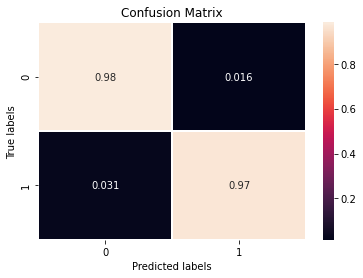

In [24]:
y_true = np.concatenate(fold_y)
y_pred = np.concatenate(fold_pred)
cm = confusion_matrix(y_true, y_pred, normalize='true')

ax = plt.subplot()
sns.heatmap(cm, annot=True, linewidth=.5)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix');

If we apply the confusion matrix here, we see that the results are pretty good no matter what type of label we have. This is much better in term of results, not only for the value of the accuracy but also for not having bias into any of the labels.

The split done on the other dataset could be biased by the partition of the data, remember that was always the same split (in order to reproduce the samples),so it could split in a way that, for example, was taking out too much positive reviews.

In [26]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1502
           1       0.98      0.97      0.98      1498

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000

